In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:2

env: CUBLAS_WORKSPACE_CONFIG=:4096:2


In [2]:
## Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import copy
import time
import datetime
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score, mean_absolute_error, accuracy_score
import sklearn.metrics as metrics
import seaborn
from torch.autograd import Variable
from pathlib import Path

## Path selection
LOCAL = True
BASE_DIR = ''

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)   
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

## Import modules

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
sys.path.append(BASE_DIR + 'models')
from preprocessing import process_sakt, save_h5
from models import DKT, SAKT, SAINT, KEETAR, NoamOpt
import dataset_parameters as params

## Set to true to just load checkpoint file

SKIP_TRAINING = True

## Dataset selection

DATASET = 'akribian'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
# DATASET = 'ednet'

## Model selection

MODEL='LSTM'
# MODEL='SAKT'
# MODEL='SAINT'
# MODEL='KEETAR'

## Prediction mode selection

# MODE = 'latency'
MODE = 'correctness'

## Set paths

CHECKPOINT_NAME= MODE + '_' + MODEL + '_' + DATASET
# File paths
IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/' 
INPUT_PATH = IN_DATA_PATH + "processed.h5"
MODEL_PATH = BASE_DIR + 'models/checkpoints/' 
FIGURE_PATH = BASE_DIR + 'figures/'

## Load dataset parameters

TIME_STEPS = params.time_steps_dict[DATASET]
NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_IDS = params.exercise_id_dict[DATASET]
TIME_SCALE = params.time_scale_dict[DATASET]

## Training parameters

BATCH_SIZE = 64     # How many sequences to backprop at the same time
LATENT_DIM = 128    # Dimension of the model
EMBED_DIM = 128     # Dimension of the embeddings
SHUFFLE = True      # Whether to shuffle training data before feeding into the model
EPOCHS = 1000       # Max number of epochs
ROWS_PER_READ = 100000  # How many rows to read from file at a time
HEADS_EN = 2        # Number of encoder heads
LAYERS_EN = 2       # Layers of encoder to use
HEADS_DE = 2        # Number of decoder heads
LAYERS_DE = 2       # Layers of decoder to use
LSTM_LAYERS = 2     # Layers of LSTM to use
WARMUP = 8000       # Warmup for Noam scheme
DROPOUT = 0.2       # Dropout probability
WEIGHT_DECAY = 1e-3 # Weight decay when using AdamW
EARLY_STOPPING_TOLERANCE = 3 # How many iterations without improvement to wait before interrupting training
EARLY_STOPPING_MIN_DIFF = 0.001

## Model parameters

# Turn individual input features on or off
USE_ID_EMBED = True         # Exercise ID embed
USE_CAT_EMBED = True        # Exercise category embed
USE_POS_EMBED = True        # Positional encoding (highly recommended for attention, but discouraged for RNN)
USE_PAST_CORRECTNESS = True # Past correctness embed
USE_ELAPSED_TIME = True     # Past elapsed time
USE_TIMESTAMP = True        # Timestamp difference
USE_MEAN_ELAPSED = True     # Mean elapsed time
USE_MEAN_CORRECTNESS = True # Mean correctness

# Input feature modifications
USE_ZSCORE = True # Z-score past elapsed time
USE_SINUSOIDAL_POS = True # Use sinus positions

# Use only last query to reduce matmul complexity for long sequences at the cost of performance hit
USE_Q_TRICK = False
# Only use last output when evaluating
USE_LAST_EVAL = False

# Whether to load relation matrix from file to augment attention weights (needs input file from '../preprocessing/relation_matrix.ipynb')
USE_RELATION_MATRIX = False
# Whether to preload entire relation matrix into GPU memory
PRELOAD_RELATION_MATRIX = False
# Sparsity threshold for relation matrix
THETA = 0.8
# Mixing coefficient for relation matrix
LAMBDA = 0.5



In [3]:
# Check if GPU available for training
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


In [4]:
# Load relation matrix if needed
if USE_RELATION_MATRIX:
    RELATION_MATRIX = np.load(IN_DATA_PATH + 'relation_matrix.npy')
    RELATION_MATRIX[RELATION_MATRIX < THETA] = 0.
    if PRELOAD_RELATION_MATRIX:
        RELATION_MATRIX = torch.from_numpy(RELATION_MATRIX).cuda()
else:
    RELATION_MATRIX = None

# Model training

In [5]:
# Create model with global hyperparams
if MODEL == 'KEETAR':
    model = KEETAR(dim_model=LATENT_DIM,
                seq_len=TIME_STEPS,
                num_en=LAYERS_EN,
                heads_en=HEADS_EN,
                total_ex= NUMBER_OF_IDS,
                total_cat= NUMBER_OF_EXERCISES,
                total_in= 3,
                dropout = DROPOUT,
                q_trick = USE_Q_TRICK,
                dim_embed = EMBED_DIM,
                use_id_embed=USE_ID_EMBED, 
                use_cat_embed=USE_CAT_EMBED,
                use_mean_elapsed=USE_MEAN_ELAPSED,
                use_mean_correctness=USE_MEAN_CORRECTNESS,
                use_pos_embed=USE_POS_EMBED,
                use_past_correctness=USE_PAST_CORRECTNESS,
                use_elapsed_time=USE_ELAPSED_TIME,
                use_timestamp=USE_TIMESTAMP,
                use_sinusoidal_pos=USE_SINUSOIDAL_POS,
                mode=MODE,
                relation_matrix=RELATION_MATRIX,
                preload_relation_matrix=PRELOAD_RELATION_MATRIX,
                blending=LAMBDA,
                lstm_layers=LSTM_LAYERS).cuda()
if MODEL == 'LSTM':
    model = DKT(dim_model=LATENT_DIM,
                dim_embed = EMBED_DIM,
                seq_len=TIME_STEPS,
                total_ex= NUMBER_OF_IDS,
                total_cat= NUMBER_OF_EXERCISES,
                total_in= 3,
                dropout = DROPOUT,
                use_id_embed=USE_ID_EMBED, 
                use_cat_embed=USE_CAT_EMBED,
                use_mean_elapsed=USE_MEAN_ELAPSED,
                use_mean_correctness=USE_MEAN_CORRECTNESS,
                use_pos_embed=USE_POS_EMBED,
                use_past_correctness=USE_PAST_CORRECTNESS,
                use_elapsed_time=USE_ELAPSED_TIME,
                use_timestamp=USE_TIMESTAMP,                
                use_sinusoidal_pos=USE_SINUSOIDAL_POS,
                mode=MODE,
                lstm_layers=LSTM_LAYERS).cuda()

if MODEL == 'SAINT':
    model = SAINT(  dim_model=LATENT_DIM,
                    seq_len=TIME_STEPS,
                    num_en=LAYERS_EN,
                    heads_en=HEADS_EN,
                    num_de=LAYERS_DE,
                    heads_de=HEADS_DE,
                    total_ex= NUMBER_OF_IDS,
                    total_cat= NUMBER_OF_EXERCISES,
                    total_in= 3,
                    dropout = DROPOUT,
                    use_sinusoidal_pos = USE_SINUSOIDAL_POS,
                    mode=MODE).cuda()

if MODEL == 'SAKT':
    model = SAKT( ex_total = NUMBER_OF_IDS,
                cat_total = NUMBER_OF_EXERCISES,
                seq_len = TIME_STEPS,
                dim = LATENT_DIM,
                heads = HEADS_EN,
                dout = DROPOUT,
                use_id_embed=USE_ID_EMBED, 
                use_cat_embed=USE_CAT_EMBED,
                use_mean_elapsed=USE_MEAN_ELAPSED,
                use_mean_correctness=USE_MEAN_CORRECTNESS,
                use_pos_embed=USE_POS_EMBED,
                use_past_correctness=USE_PAST_CORRECTNESS,
                use_elapsed_time=USE_ELAPSED_TIME,
                use_timestamp=USE_TIMESTAMP,
                use_sinusoidal_pos=USE_SINUSOIDAL_POS,
                mode=MODE).cuda()

# Set loss function according to mode
if MODE == 'correctness':
    criterion = nn.BCELoss()
if MODE == 'latency':
    criterion = nn.MSELoss()

## Optimizer selection

# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Simple optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8) # Default
# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY) # Default with added weight decay
# optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)) # Default with Noam scheme
# optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY)) # Noam scheme and weight decay

print("Model created successfully.")

Model created successfully.


In [6]:
if not SKIP_TRAINING:
  ## Training the model
  print_freq = 10
  graph_freq = 10

  losses_history = []

  val_r2 = []
  val_mae = []
  val_aucs = []

  previous_mae = 9999.
  previous_auc = 0.

  no_improvement_streak = 0
  best_mae = 9999.
  best_auc = 0.

  with h5py.File(INPUT_PATH,'r') as h5_file:

    # Count how many data points we have
    print("Counting number of windows...")
    number_of_train_windows = h5_file['exercises_train'].len()
    number_of_val_windows = h5_file['exercises_val'].len()
    print("Done.")

    actual_epochs = 0
    training_start_time = time.time()

    # Iterate over epochs
    for epoch in range(EPOCHS):
      epoch_start_time = time.time()
      actual_epochs += 1

      print("Epoch %i" % (epoch+1))
      total_loss_print = 0.0
      total_loss_graph = 0.0

      # Read set number of lines from dataset
      for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

        # Read data
        exercises_train = h5_file['exercises_train'][read_index:read_index+ROWS_PER_READ]
        exercise_ids_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
        past_labels_train = h5_file['past_labels_train'][read_index:read_index+ROWS_PER_READ]
        elapsed_train = h5_file['elapsed_train'][read_index:read_index+ROWS_PER_READ]
        past_zscore_train = h5_file['past_elapsed_zscore_train'][read_index:read_index+ROWS_PER_READ]
        current_elapsed_train = h5_file['current_elapsed_train'][read_index:read_index+ROWS_PER_READ]
        current_elapsed_mean_train = h5_file['current_elapsed_mean_train'][read_index:read_index+ROWS_PER_READ]
        current_correctness_mean_train = h5_file['current_correctness_mean_train'][read_index:read_index+ROWS_PER_READ]
        timestamp_train = h5_file['timestamps_train'][read_index:read_index+ROWS_PER_READ]
        labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]

        # Shuffle data if needed
        random_indices = np.arange(len(exercises_train))
        if SHUFFLE:
          np.random.shuffle(random_indices)
        exercises_train = exercises_train[random_indices]
        exercise_ids_train = exercise_ids_train[random_indices]
        past_labels_train = past_labels_train[random_indices]
        elapsed_train = elapsed_train[random_indices]
        past_zscore_train = past_zscore_train[random_indices]
        timestamp_train = timestamp_train[random_indices]
        current_elapsed_train = current_elapsed_train[random_indices]
        current_elapsed_mean_train = current_elapsed_mean_train[random_indices]
        current_correctness_mean_train = current_elapsed_mean_train[random_indices]
        labels_train = labels_train[random_indices]

        ## Training step

        # Set model to training mode
        model.train()

        # Iterate over batches
        for idx in range(0, len(exercises_train), BATCH_SIZE):
          # Load batch into GPU
          cat_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
          id_samples = torch.from_numpy(exercise_ids_train[idx:idx + BATCH_SIZE]).long().cuda()
          shifted_label = torch.from_numpy(past_labels_train[idx:idx + BATCH_SIZE]).long().cuda()
          elapsed = torch.from_numpy(past_zscore_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda() if USE_ZSCORE else torch.from_numpy(elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          current_elapsed = torch.from_numpy(current_elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda() / TIME_SCALE
          current_elapsed_mean = torch.from_numpy(current_elapsed_mean_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          current_correctness_mean = torch.from_numpy(current_correctness_mean_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          timestamp = torch.from_numpy(timestamp_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).unsqueeze(2).long().cuda()

          # Reset optimizer gradients
          optimizer.zero_grad()

          # Predict
          out = model(id_samples, cat_samples, shifted_label, elapsed, timestamp, current_elapsed_mean, current_correctness_mean)

          # Check if we have NaN in output
          if torch.isnan(out).any():
            print("Model output contains nan")
            bad_index = torch.isnan(out.squeeze())
            print("Offending input:")
            print("First ID in time series in batch:")
            print(id_samples[:,0])
            raise Exception("Model output contains nan")

          # Calculate loss 
          loss = criterion(out, current_elapsed.float() if MODE=='latency' else label.float())
          total_loss_print += loss.item()
          total_loss_graph += loss.item()

          # Optimize
          loss.backward()
          optimizer.step()

          # Print status
          idx_discrete = int(idx / BATCH_SIZE)
          if (idx_discrete % print_freq == print_freq - 1):
            avg_loss = total_loss_print/print_freq
            sys.stdout.write("\rTraining %i/%i, avg loss %.5f, %s" % (idx+1 + read_index, number_of_train_windows, avg_loss, str(datetime.timedelta(seconds=int(time.time() - epoch_start_time))) ))
            sys.stdout.flush()
            total_loss_print = 0.0

          # Append to graph
          if (idx_discrete % graph_freq == graph_freq - 1):
            avg_loss = total_loss_graph/graph_freq
            losses_history.append(avg_loss)
            total_loss_graph = 0.0
              
      ## Validation step
      # Set model to evaluation mode
      model.eval()
      outs_preds = np.array([])
      val_labels_last = np.array([])
      val_start_time = time.time()
      print()
      # Turn off grad calculation
      with torch.no_grad():
        # Iterate through val data
        for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
          exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
          exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
          labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
          past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
          elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
          past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
          timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
          current_elapsed_val = h5_file['current_elapsed_val'][read_index:read_index+ROWS_PER_READ]
          current_elapsed_mean_val = h5_file['current_elapsed_mean_val'][read_index:read_index+ROWS_PER_READ]
          current_correctness_mean_val = h5_file['current_correctness_mean_val'][read_index:read_index+ROWS_PER_READ]

          for idx in range(0, len(exercises_val), BATCH_SIZE):

            # Print status
            idx_discrete = int(idx / BATCH_SIZE)
            if (idx_discrete % print_freq == print_freq - 1):
              sys.stdout.write("\rEvaluating %i/%i, %s" % (idx+1 + read_index, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
              sys.stdout.flush()

            cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
            id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
            shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
            elapsed = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda() if USE_ZSCORE else torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
            timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
            current_elapsed_mean = torch.from_numpy(current_elapsed_mean_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
            current_correctness_mean = torch.from_numpy(current_correctness_mean_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
            current_elapsed = current_elapsed_val[idx:idx + BATCH_SIZE] / TIME_SCALE
            label = labels_val[idx:idx + BATCH_SIZE] if MODE=='correctness' else current_elapsed

            # Predict
            outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val, elapsed, timestamp, current_elapsed_mean, current_correctness_mean)        

            if USE_LAST_EVAL or USE_Q_TRICK:
              ## method 2: slice only the last non-padding element
              last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
              outs_pred_indexed = outs_pred.squeeze(2).gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
              label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()
            else:
              ## method 1: slice entire sequence
              padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      
              outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
              outs_pred_indexed = outs_pred_np[padding_mask]
              label_indexed = label[padding_mask]

            val_labels_last = np.append(val_labels_last, label_indexed)
            outs_preds = np.append(outs_preds, outs_pred_indexed)

      # Revert to training mode
      model.train()

      # Evaluate and check for improvement
      improvement = False

      if MODE == 'correctness':
        fpr, tpr, thresholds = roc_curve(val_labels_last, outs_preds)
        auc_score = auc(fpr, tpr)
        val_aucs.append(auc_score)    

        print("\nValidation AUC: %f" % auc_score)
        auc_diff = auc_score - previous_auc
        if epoch != 0:
          print("AUC difference: %f" % auc_diff)

        if auc_score >= best_auc:
          improvement = True
          best_auc = auc_score
        previous_auc = auc_score

      if MODE == 'latency':
        r2 = metrics.r2_score(val_labels_last, outs_preds)
        mae = metrics.mean_absolute_error(val_labels_last, outs_preds)
        val_r2.append(r2)
        val_mae.append(mae)
        print("\nValidation R2: %f" % r2)
        mae_diff = mae - previous_mae
        if epoch != 0:
          print("MAE difference: %f" % mae_diff)
        else:
          best_mae = mae

        print("Validation MAE: %f" % mae)
        print("Validation MAE (seconds): %.3f" % (mae * TIME_SCALE))

        if mae <= best_mae:
          improvement=True
          best_mae = mae
        previous_mae = mae

      if improvement:
        no_improvement_streak = 0
        torch.save(model.state_dict(), MODEL_PATH + CHECKPOINT_NAME + ".torch")
        print("Model saved")
      else:
        no_improvement_streak += 1

      if no_improvement_streak >= EARLY_STOPPING_TOLERANCE:
        break

  print("%i epochs completed in %s" % (actual_epochs, str(datetime.timedelta(seconds=int(time.time() - training_start_time)))))

In [7]:
if not SKIP_TRAINING:
    graphs_per_epoch = number_of_train_windows / BATCH_SIZE / graph_freq
    xs = np.arange(len(losses_history)) / graphs_per_epoch
    plt.figure(1)
    plt.plot(xs, losses_history)
    plt.title("Loss over epochs")
    plt.yscale('log')
    if MODE=='latency':
        plt.figure(2)
        plt.plot(val_r2)
        plt.title("R2 over epochs")
        plt.figure(3)
        plt.plot(val_mae)
        plt.title("MAE over epochs")
    if MODE=='correctness':
        plt.figure(2)
        plt.plot(val_aucs)
        plt.title("AUC over epochs")

In [8]:
# Load the best model
model.load_state_dict(torch.load(MODEL_PATH + CHECKPOINT_NAME + ".torch"))

<All keys matched successfully>

In [9]:
model.eval()

outs_preds = np.array([])
val_labels_last = np.array([])
val_start_time = time.time()

print_freq = 10
graph_freq = 10

BATCH_SIZE = BATCH_SIZE 

# Predict iteratively in batches to avoid overloading VRAM
with h5py.File(INPUT_PATH,'r') as h5_file:
  number_of_val_windows = h5_file['exercises_val'].shape[0]
  with torch.no_grad():
      # Iterate through val data
      for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
        exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
        exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
        labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
        past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
        elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
        past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
        timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
        current_elapsed_val = h5_file['current_elapsed_val'][read_index:read_index+ROWS_PER_READ]
        current_elapsed_mean_val = h5_file['current_elapsed_mean_val'][read_index:read_index+ROWS_PER_READ]
        current_correctness_mean_val = h5_file['current_correctness_mean_val'][read_index:read_index+ROWS_PER_READ]

        for idx in range(0, len(exercises_val), BATCH_SIZE):

          # Print status
          idx_discrete = int(idx / BATCH_SIZE)
          if (idx_discrete % print_freq == print_freq - 1):
            sys.stdout.write("\rEvaluating %i/%i, %s" % (idx+1 + read_index, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
            sys.stdout.flush()

          cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
          id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
          shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
          elapsed = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda() if USE_ZSCORE else torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          current_elapsed_mean = torch.from_numpy(current_elapsed_mean_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          current_correctness_mean = torch.from_numpy(current_correctness_mean_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
          current_elapsed = current_elapsed_val[idx:idx + BATCH_SIZE] / TIME_SCALE
          label = labels_val[idx:idx + BATCH_SIZE] if MODE=='correctness' else current_elapsed

          # Predict
          outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val, elapsed, timestamp, current_elapsed_mean, current_correctness_mean)        

          if USE_LAST_EVAL or USE_Q_TRICK:
            ## method 2: slice only the last non-padding element
            last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
            outs_pred_indexed = outs_pred.squeeze(2).gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
            label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()
          else:
            ## method 1: slice entire sequence
            padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      
            outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
            outs_pred_indexed = outs_pred_np[padding_mask]
            label_indexed = label[padding_mask]

          val_labels_last = np.append(val_labels_last, label_indexed)
          outs_preds = np.append(outs_preds, outs_pred_indexed)

print("\nDone!")
if MODE == 'correctness':
  print("Validation labels correct ratio: %.3f" % np.mean(val_labels_last))

Evaluating 4305/4360, 0:00:08
Done!


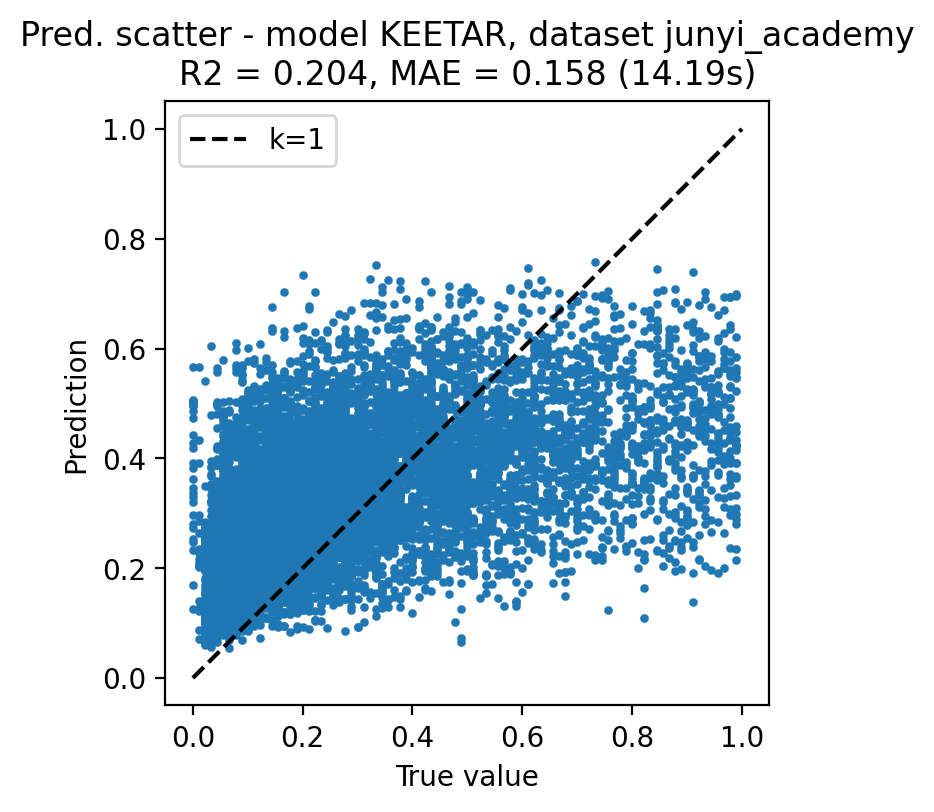

In [10]:
if MODE == 'latency':
    fig = plt.figure(dpi=200)
    r2 = metrics.r2_score(val_labels_last, outs_preds)
    mae = metrics.mean_absolute_error(val_labels_last, outs_preds)
    ax1 = fig.add_subplot(111)
    ax1.scatter(val_labels_last[:10000], outs_preds[:10000], linewidth=0.1, edgecolor=None, marker='.')
    ax1.plot([0, 1.], [0, 1.], 'k--', label='k=1')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('True value')
    plt.ylabel('Prediction')
    plt.legend()
    plt.title("Pred. scatter - model " + MODEL + ", dataset " + DATASET + "\nR2 = %.3f, MAE = %.3f (%.2fs)" % (r2, mae, mae * TIME_SCALE))
    plt.savefig(FIGURE_PATH + CHECKPOINT_NAME + "_R2.png", dpi=200)
if MODE=='correctness':
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_labels_last, outs_preds)
    auc_score = auc(fpr_keras, tpr_keras)
    # This one reports too high auc...
    #auc_score = roc_auc_score(val_labels_last, outs_preds)

    plt.figure(3, figsize=(12,8), dpi=80)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.4f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(FIGURE_PATH + CHECKPOINT_NAME + "_AUC.png", dpi=200)

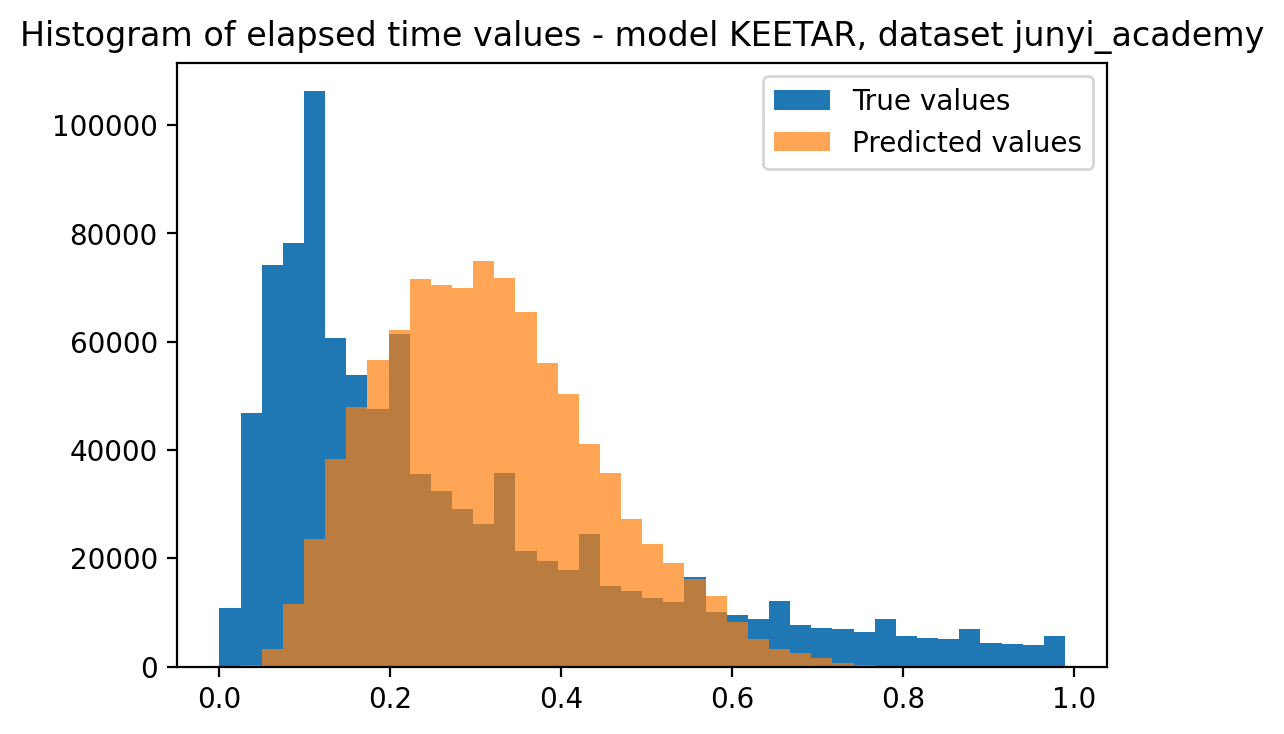

In [11]:
if MODE=='latency':
    fig = plt.figure(dpi=200)
    _, bins, _ = plt.hist(val_labels_last * (1. if USE_ZSCORE else TIME_SCALE), bins=40, alpha=1., label='True values')
    plt.hist(outs_preds * (1. if USE_ZSCORE else TIME_SCALE), bins=bins, alpha=0.7, label='Predicted values')
    plt.legend()
    plt.title("Histogram of elapsed time values - model " + MODEL + ", dataset " + DATASET)
    plt.savefig(FIGURE_PATH + CHECKPOINT_NAME + "_hist.png", dpi=200)
# if MODE=='correctness':
    # img_width = TIME_STEPS
    # max_width = 30

    # # Define image
    # img = np.ndarray((3, img_width))
    # img = img[:, :max_width]

    # # Set category color
    # ex_color = exercises_test.squeeze().cpu().detach().numpy()
    # color_dict = dict(enumerate(list(set(ex_color))))
    # color_dict = {v:k for k,v in color_dict.items()}
    # colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
    # colors = colors[-max_width:]
    # img[0,:] = colors

    # # Set ground truth color
    # ground_truth = ground_truth[-max_width:]
    # img[1,:] = ground_truth

    # # Set prediction color
    # pred = pred[-max_width:]
    # img[2,:] = pred

    # # Show the figure
    # plt.figure(4, figsize=(12,8), dpi=100)
    # plt.imshow(img)
    # plt.text(max_width, 0.15, "Category")
    # plt.text(max_width, 1.15, "Ground truth")
    # plt.text(max_width, 2.15, "Prediction")

    # # Index
    # print("Index: %i" % idx)
    # plt.savefig(FIGURE_PATH + CHECKPOINT_NAME + "_example.png", dpi=200)

# Baseline

In [12]:
if MODE == 'latency':
    label_key = 'current_elapsed'
else:
    label_key = 'labels'

# Baseline
# Mean latency per question
with h5py.File(INPUT_PATH,'r') as h5_file:
    exercise_ids = h5_file['exercise_ids_train'][:]
    labels = h5_file[label_key + '_train'][:]
    exercise_ids_val = h5_file['exercise_ids_val'][:]
    labels_val = h5_file[label_key + '_val'][:]
padding_mask = exercise_ids > 0
training = pd.DataFrame(data=np.transpose(np.stack((exercise_ids[padding_mask], labels[padding_mask]))), index=np.arange(exercise_ids[padding_mask].size), columns=['id','label'])
training['id'] = pd.to_numeric(training['id'], downcast='integer')
mean_dict = training.groupby('id').mean().to_dict()['label']
global_mean = np.mean(labels[padding_mask])
padding_mask_val = exercise_ids_val > 0
baseline_prediction = np.array([mean_dict.get(exid, global_mean) for exid in exercise_ids_val[padding_mask_val]])

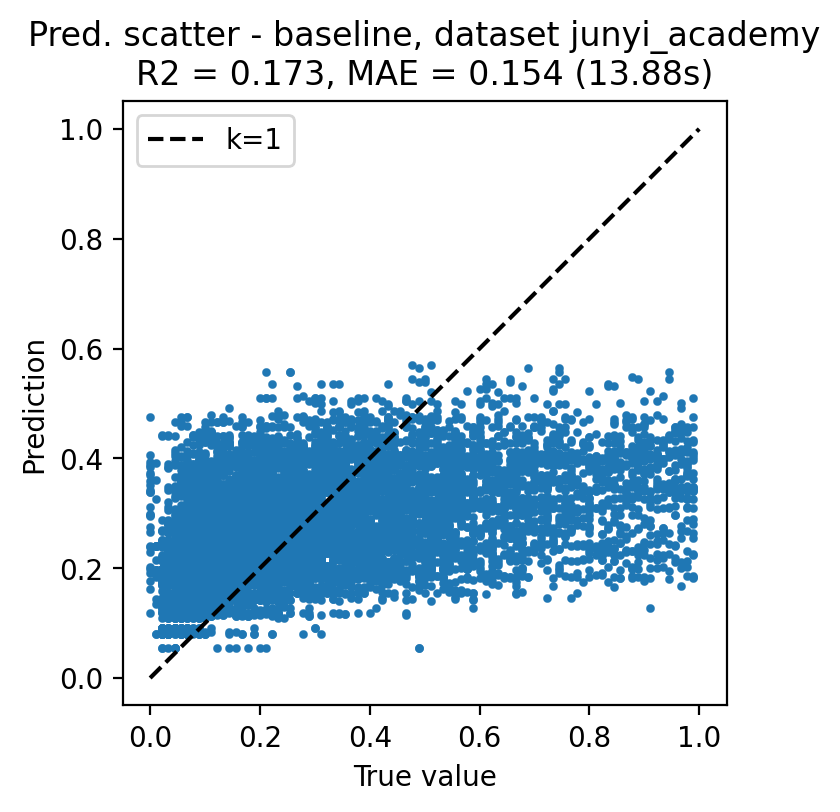

In [13]:
val_labels_last = labels_val[padding_mask_val] / (TIME_SCALE if MODE == 'latency' else 1.0)
outs_preds = baseline_prediction / (TIME_SCALE if MODE == 'latency' else 1.0)

if MODE == 'latency':
    fig = plt.figure(dpi=200)
    r2 = metrics.r2_score(val_labels_last, outs_preds)
    mae = metrics.mean_absolute_error(val_labels_last, outs_preds)
    ax1 = fig.add_subplot(111)
    ax1.scatter(val_labels_last[:10000], outs_preds[:10000], linewidth=0.1, edgecolor=None, marker='.')
    ax1.plot([0, 1.], [0, 1.], 'k--', label='k=1')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('True value')
    plt.ylabel('Prediction')
    plt.legend()
    plt.title("Pred. scatter - baseline, dataset " + DATASET + "\nR2 = %.3f, MAE = %.3f (%.2fs)" % (r2, mae, mae*TIME_SCALE))
    plt.savefig(FIGURE_PATH + 'latency_BASELINE_' + DATASET + "_R2.png", dpi=200)
if MODE=='correctness':
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_labels_last, outs_preds)
    auc_score = auc(fpr_keras, tpr_keras)
    # This one reports too high auc...
    #auc_score = roc_auc_score(val_labels_last, outs_preds) 

    plt.figure(3, figsize=(12,8), dpi=80)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.4f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("ROC curve - baseline, dataset " + DATASET + "\nAUC = %.4f" % auc_score)
    plt.legend(loc='best')
    plt.show()
    plt.savefig(FIGURE_PATH + "correctness_BASELINE_" + DATASET + "_.png", dpi=200)


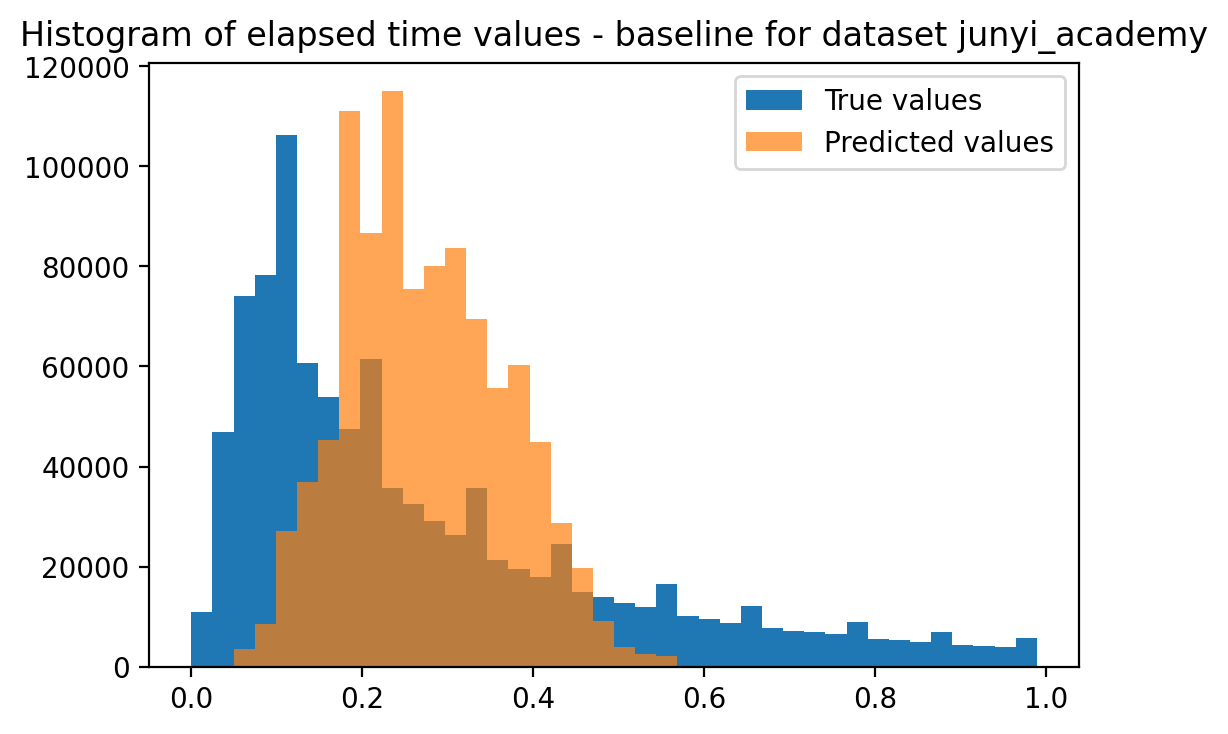

In [14]:
if MODE=='latency':
    fig = plt.figure(dpi=200)
    _, bins, _ = plt.hist(val_labels_last * (1. if USE_ZSCORE else TIME_SCALE), bins=40, alpha=1., label='True values')
    plt.hist(outs_preds * (1. if USE_ZSCORE else TIME_SCALE), bins=bins, alpha=0.7, label='Predicted values')
    plt.legend()
    plt.title("Histogram of elapsed time values - baseline for dataset " + DATASET)
    plt.savefig(FIGURE_PATH + 'latency_BASELINE_' + DATASET + "_hist.png", dpi=200)